# 1. Business Understanding

## 1.1 Background

Facial recognition is used in a variety of ways within the software industry. One example is Facebook's automatic tagging. When a user posts a picture of them and their friends, Facebook will look at the picture and tag any of the user's friends with their profile. No longer do users have to manually tag their friends on posts. Another use of facial recognition is identifying endangered species in the wild to protect them. With a collection of well-positioned cameras, park rangers and researchers are able to easily monitor wildlife remotely, and the use of facial recognition software allows them to automatically track the locations of endangered species as well as poachers. The popular use of facial modifications through the use of filters such as those found in the popular mobile application *SnapChat* demonstrate this technology is a useful tool in the social media and entertainment industry, as well.

Creating classification models for animal breeds provide a variety of uses. According to the American Humane Society, 10 million household pets are lost every year in the United States. Only a fraction of those pets end up in animal shelters, and many of them won't ever be reunited with their owners. Animal facial recognition technology can help pet owners find their lost pets in conjunction with the numerous public-facing cameras in city streets. Self-driving cars also greatly leverage the use of computer vision technology. Although car manufacturers are more concerened about human lives, animal-related car accidents and fatalities are not uncommon. Being able to identify a large moose on snowy Canadian roads could prevent a major car accident, and the ability to recognize a cat or dog on the road can prevent the loss of someone's pet. The usage of image recognition software is wide-ranging, but we know it is incredibly useful in today's world.

https://americanhumane.org/blog/every-day-is-tag-day-is-your-pet-protected/#:~:text=Each%20year%2C%20approximately%2010%20million,in%20the%20nation's%20animal%20shelters.

https://www.nathab.com/blog/self-driving-vehicles-could-save-animal-lives

## 1.2 Value Proposition

The cat and dog faces dataset is a subset of Cornell University's STARGan v2 dataset of high quality animal faces. These images are useful for solving image-to-image translation problems, where the goal is to learn the mapping between an input image and an output image. A practical application for this would be the use of computer-generated imagery in films and image-editing. Creating software that provides high qualilty, accurate, and fast image-to-image translation using these images can provide great value to the entertainment and other industries.

For our purposes, we are concerned with classifying these images and creating accurate captions. By generating accurate descriptions for these images, we can help create better tools for animal shelters and wildlife protection organizations for in-depth animal identification tasks.

https://github.com/clovaai/stargan-v2

## 1.3 Measure of Success

Since there exists two different classes in our animal dataset, cat or dog, we expect our predictions to yield a nearly 100% success rate given inputs with the same quality of those within our dataset. The original purpose of the dataset was not image classification so we cannot create a measure of success based on a measure stated within the associated paper. But, as the classification task associated with the dataset will be binary, the classification must, at minimum, be better than coin flips yielding 50% accuracy.

In [1]:
from typing import *
import cv2
import os 
import glob

def get_list_of_imgs(folder_path: str) -> List:
    data_path = os.path.join(folder_path,'*g') 
    files = glob.glob(data_path) 
    list_of_imgs = [] 
    for f1 in files: 
        img = cv2.imread(f1)
        img_resized = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_CUBIC)
        list_of_imgs.append(img_resized)
    return list_of_imgs

cat_folder_path = './cats'
dog_folder_path = './dogs'

In [2]:
list_of_cat_imgs = get_list_of_imgs(cat_folder_path)
print(f'Loaded {len(list_of_cat_imgs)} cat images')
list_of_dog_imgs = get_list_of_imgs(dog_folder_path)
print(f'Loaded {len(list_of_dog_imgs)} dog images')

Loaded 500 cat images
Loaded 500 dog images


In [3]:
import numpy as np

def list_to_numpy_array(img):
    return np.asarray(img, dtype=np.float32)

def grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.144])

def grayscale_imgs(list_of_imgs):
    return list_to_numpy_array([grayscale(img) for img in list_of_imgs])

np_cat = grayscale_imgs(list_of_cat_imgs)
np_dog = grayscale_imgs(list_of_dog_imgs)

In [4]:
import matplotlib.pyplot as plt

def plot_gallery(images, titles=None, h=128, w=128, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles: plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

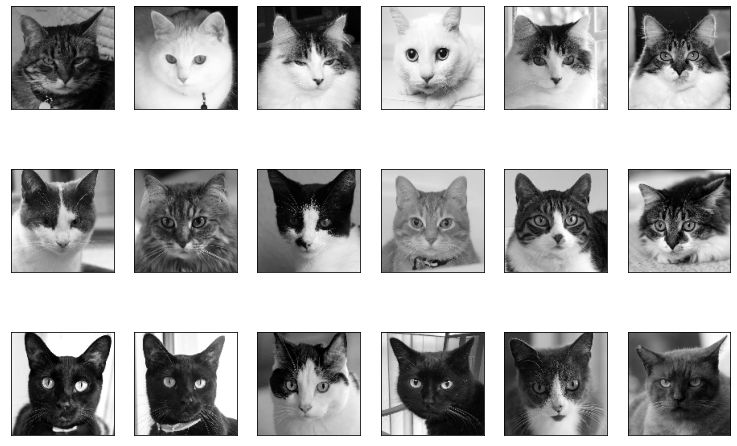

In [5]:
plot_gallery(np_cat)

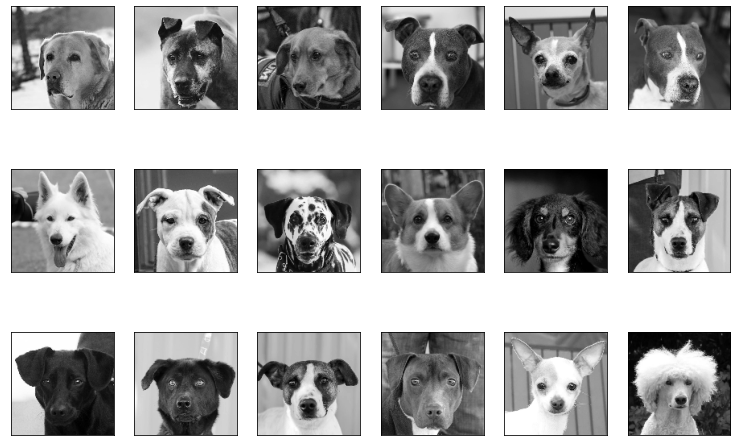

In [6]:
plot_gallery(np_dog)

## PCA

In [43]:
from sklearn.decomposition import PCA

animals = ['dog', 'cat']
np_animals = np.concatenate((np_dog, np_cat), axis=0)
animal_data = np.reshape(np_animals, (np_animals.shape[0], np_animals.shape[1]*np_animals.shape[2]))

X = animal_data
Y = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

n_samples, n_features = X.shape
_, h, w = np_animals.shape
n_classes = len(animals)

print(np.sum(~np.isfinite(X)))
print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))

n_components = 3
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenfaces = pca.components_.reshape((n_components, h, w))

0
n_samples: 1000
n_features: 16384
n_classes: 2
Original Image Sizes 128 by 128
Extracting the top 3 eigenfaces from 1000 faces
CPU times: user 1.44 s, sys: 1.7 s, total: 3.14 s
Wall time: 406 ms


IndexError: index 3 is out of bounds for axis 0 with size 3

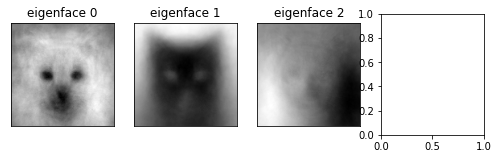

In [44]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

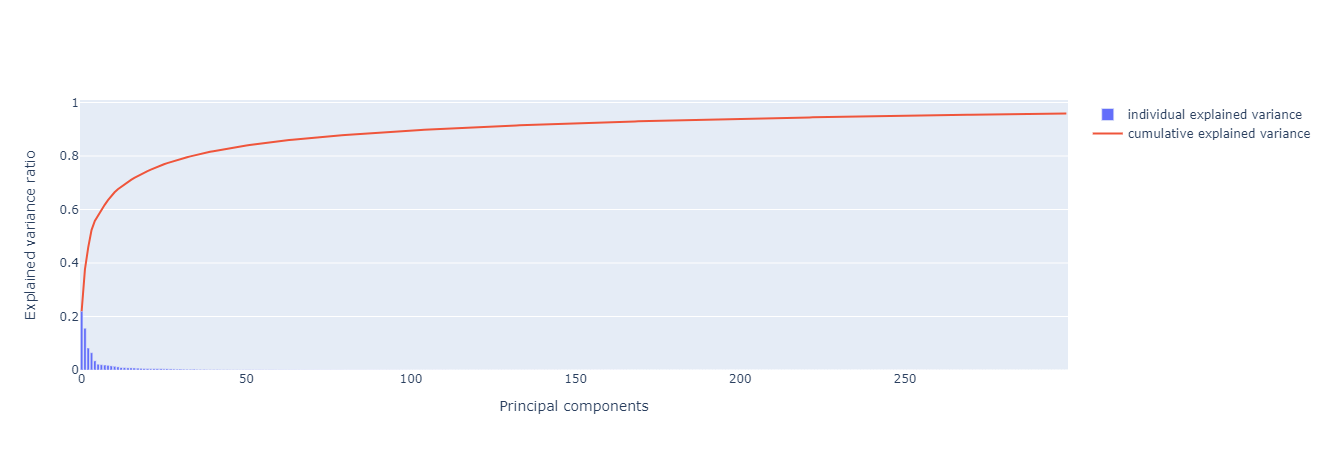

In [10]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
        })
plot_explained_variance(pca)

In [11]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1    
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

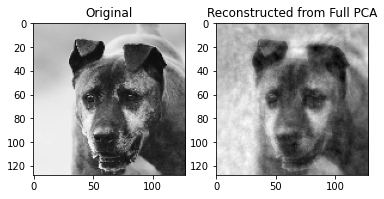

In [13]:
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

## Randomized PCA

In [14]:
n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(X.copy())
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 1000 faces
CPU times: user 11.6 s, sys: 16.2 s, total: 27.8 s
Wall time: 2.09 s


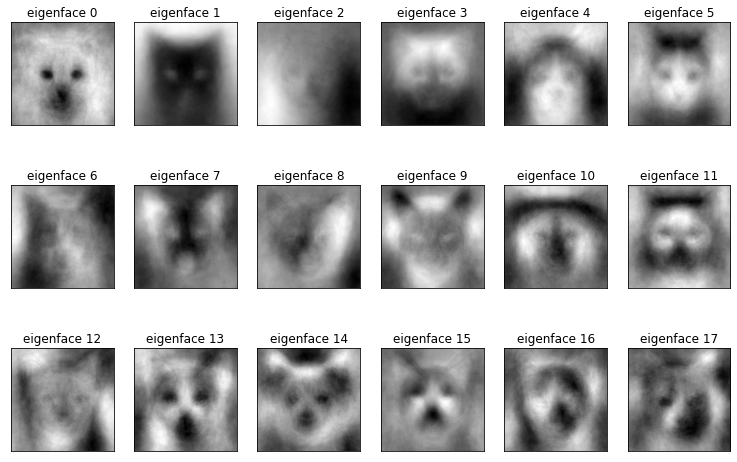

In [15]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [22]:
from ipywidgets import widgets
import warnings
# warnings.simplefilter('ignore', DeprecationWarning)
# warnings.simplefilter("always",DeprecationWarning)

def plt_reconstruct(idx_to_reconstruct):
    # this code is for reference only, it does not qualify as a neaarest neighbor search
    #  for your lab project. 
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    x_flat = X[idx_to_reconstruct].reshape(1, -1)
    reconstructed_image = pca.inverse_transform(pca.transform(x_flat.copy()))    
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(x_flat.copy()))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,3,1) # original
    plt.imshow(x_flat.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid(False)
    
    plt.subplot(1,3,2) # pca
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid(False)
    
    plt.subplot(1,3,3) # randomized pca
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid(False)
    
    
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

interactive(children=(IntSlider(value=499, description='idx_to_reconstruct', max=999), Output()), _dom_classes…

<function __main__.plt_reconstruct(idx_to_reconstruct)>